## AIDL Deep Learning and Neural Networks
### Columbia University


# Assignment 4: Application - Build CNN for a Real-world challenge
In this assignment, you will get to implement CNN model using TensorFlow (Keras) to tackle a real-world image classification challenge.

### Prepare the bottle challenge dataset

Start by uploading the presented .zip file with the dataset to your google drive, under AIDL_data/AIDL_Bottle_Challenge_Dataset.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q drive/MyDrive/AIDL_data/AIDL_Bottle_Challenge_Dataset.zip -d data/

The bottle challenge dataset structure is:

- **train_128**: training directory contains 5 subfolders, each numper represents the percentage of the liquiid inside the bottle (0: empty,1: 25%,2:50%, 3:75%, 4:full bottle)
      -- 0: bottle is empty
      -- 1: bottle is 25% full
      -- 2: bottle is 50% full
      -- 3: bottle is 75% full
      -- 4: bottle is full
- **test_128**: test folder contains 3000 images for test without any label

### Import eseential packages

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Generate customized dataset loader

In [ ]:
image_size = (128, 128) #define our image size
batch_size = 32 #define batch size
bottle_dir = 'data/AIDL_Bottle_Challenge_Dataset/train_128'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    bottle_dir,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    bottle_dir,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 15000 files belonging to 5 classes.
Using 12000 files for training.
Found 15000 files belonging to 5 classes.
Using 3000 files for validation.


#### We can visualize several samples from the dataset before moving on:

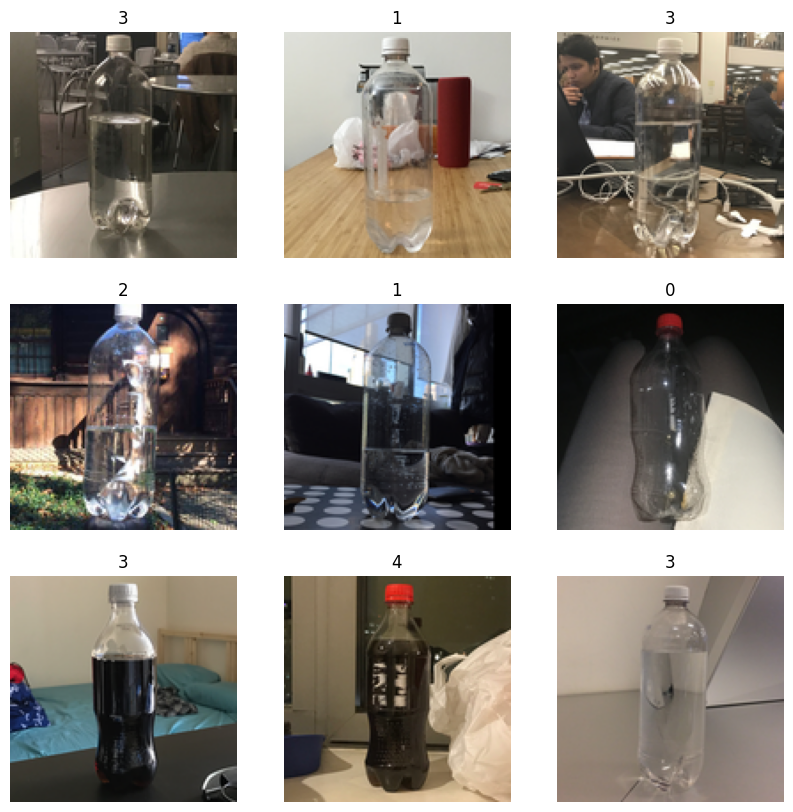

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

### Data Augmentation
To prevent overfitting during training, we can apply multiple data augmentation tricks to enlarge the dataset. For example, we can randomly flip the image and also give it some rotation here:

<span style="color:red"><strong>TODO</strong></span>: use **keras.Sequential** class to create a data augmentation pipeline with **horizontal RandomFlip** and **RandomRotation with 0.1 factor**

**Reference:**

**1. RandomFlip:** https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomFlip

**2. RandomRotation:** https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomRotation

https://www.tensorflow.org/tutorials/images/data_augmentation

https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation

https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip

In [ ]:
# %%%%%%%%%%%%%% implement your code below (1 line) %%%%%%%%%%%%%%
data_augmentation = keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1)
])
# %%%%%%%%%%%%%% your code ends here %%%%%%%%%%%%%%


Choose one image from the training dataset and let's see what happens:

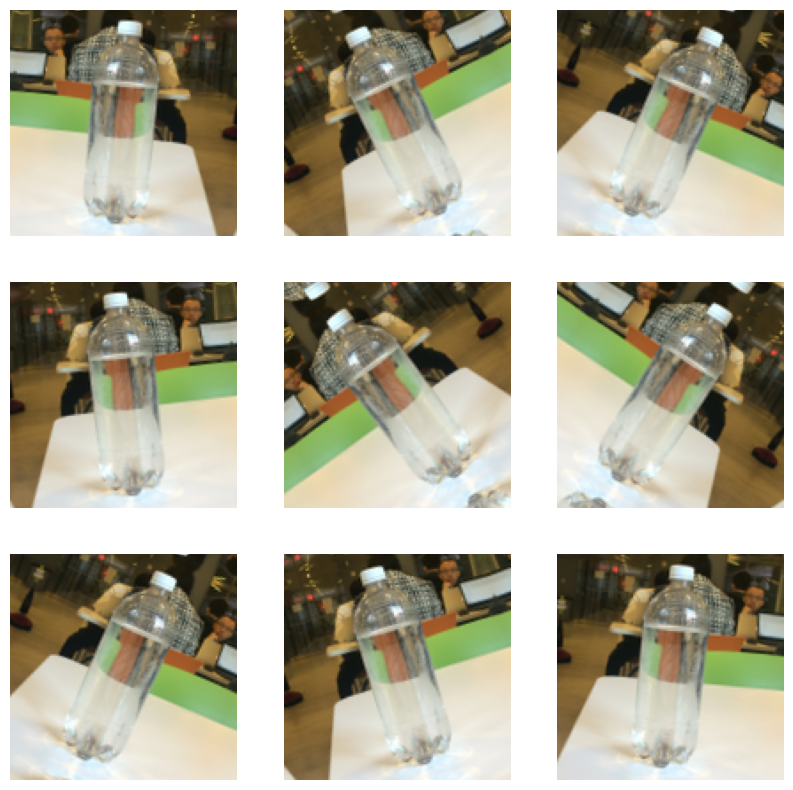

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

#### Augmentation Mapping
Then we can map this augmentation to our dataset, or we can directly insert the augmentation part into the model.

<span style="color:red"><strong>TODO</strong></span>:

1. Check Tensorflow documentation about **tf.data.Dataset** object and use embedded **map** function to map **data_augmentation** to the orignal data.

2. Check **prefetch** function from **tf.data.Dataset**, and prefetch the data with **batch size = 32** to the buffer to reduce I/O time during training.

**Reference:**

**1. tf.data.Dataset:** https://www.tensorflow.org/api_docs/python/tf/data/Dataset

**2. keras.preprocessing.image_dataset_from_directory:** https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory


In [ ]:
# %%%%%%%%%%%%%% implement your code below (4 lines) %%%%%%%%%%%%%%
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE).prefetch(buffer_size=32)  #call map function
augmented_val_ds = val_ds.map(lambda x, y: (x, y), num_parallel_calls=tf.data.AUTOTUNE).prefetch(buffer_size=32) #call map function
# %%%%%%%%%%%%%% your code ends here %%%%%%%%%%%%%%

However, current RGB value range [0,255] is not ideal for training the CNN model, we can rescale the images to [0,1] to get a better convergence. And in Keras, **rescaling** layer can easily achieve this task. We can add the **rescaling** layer inside the model:

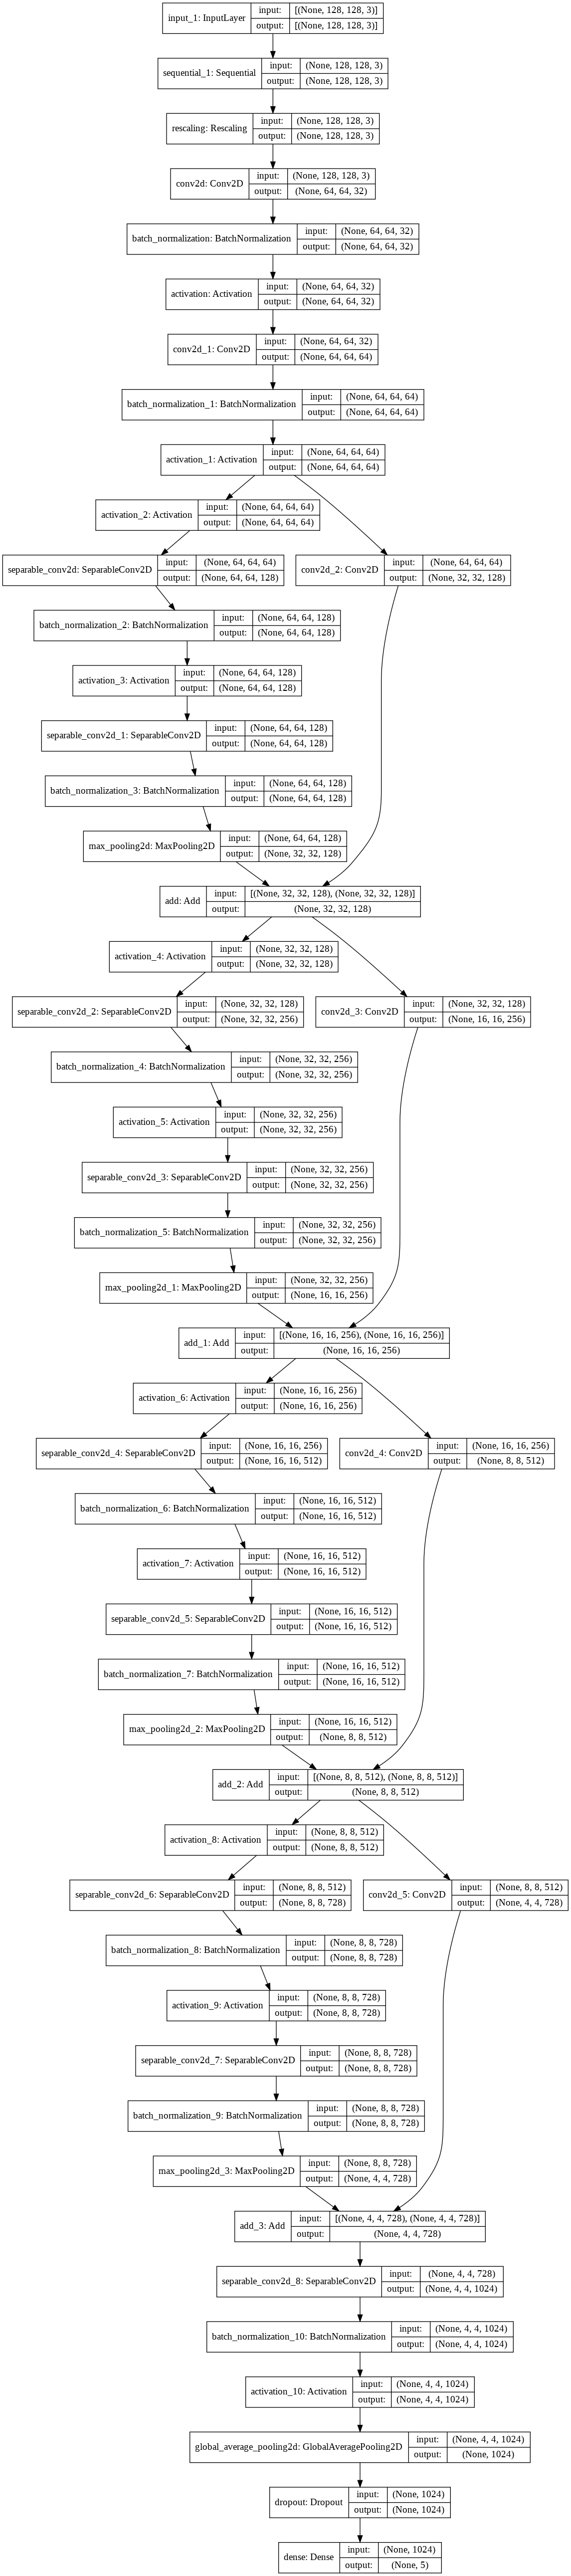

### Build Classification Model
In this assignment, we provide you a much more complex model than all the previous assignments and recitation. We provide the model structure above and you can always run the **keras.utils.plot_model** to check the structure. One of the core secton of this model is **residual block** which combines the normal **convolution-batch_norm-activation** blocks and the output from previous block as the output to enlarge the model depth and remedy gradient vanish/explosion problem.

<span style="color:red"><strong>TODO</strong></span>:

1. Check Tensorflow documentation about **Rescaling** layer and rescale the input from [0,255] to [0,1]

2. Check **layers** API and reproduce the model structure shown below (**You have to figure out several model parameters by yourself**).  


**Important tips:**

(1) In the residual blocks: all the **SeparableConv2D** layers have the same **kernel size=3** and **"same" padding**;

(2) all the **activation functions** are **"relu"**;

(3) **Conv2D** layers in the residual path have **kernel size=1, stride =2, 'same' padding** ;

(4) **BatchNormalization** layers are default;

(5) **MaxPooling2D** layers have **"same" padding**



**Reference:**

**1. rescaling layer:** https://keras.io/api/layers/preprocessing_layers/image_preprocessing/rescaling/

**2. Keras layers API:** https://keras.io/api/layers/


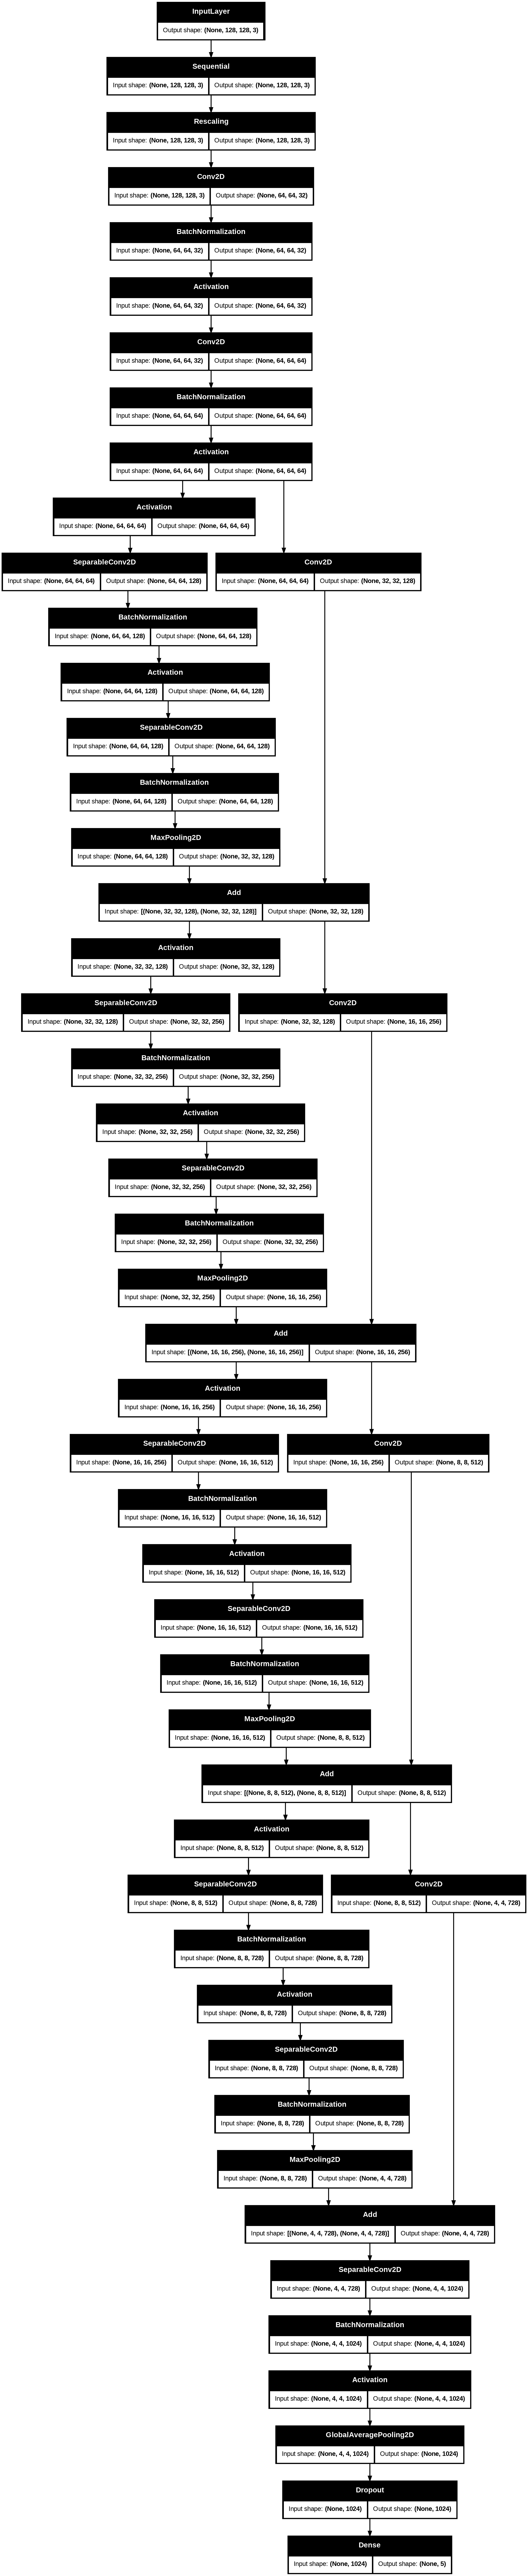

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)
    # %%%%%%%%%%%%%% implement your code below (1 line) %%%%%%%%%%%%%%
    x = layers.Rescaling(1./255)(x)
    # %%%%%%%%%%%%%% your code ends here %%%%%%%%%%%%%%
    # Entry block
    # we build several layers for you as the starting point.
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # %%%%%%%%%%%%%% implement your code below (1 line) %%%%%%%%%%%%%%
    previous_block_activation = x  # Set aside residual
    # %%%%%%%%%%%%%% your code ends here %%%%%%%%%%%%%%

    for size in [128, 256, 512, 728]:               #The channel number list can help you from laboriously repeating layers
        # %%%%%%%%%%%%%% implement your code below (7 lines) %%%%%%%%%%%%%%
        # this is the major path of the block:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        # %%%%%%%%%%%%%% your code ends here %%%%%%%%%%%%%%


        # Project residual
        # %%%%%%%%%%%%%% implement your code below (3 lines) %%%%%%%%%%%%%%
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.Add()([x, residual])
        previous_block_activation = x  # Set aside next residua
        # %%%%%%%%%%%%%% your code ends here %%%%%%%%%%%%%%
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=5)
keras.utils.plot_model(model, show_shapes=True)

### Train the model

<span style="color:red"><strong>TODO</strong></span>:

1. **Compile the model:** (1) **Adam** optimizer (learning rate = 1e-3); (2)choose correct **loss** function; (3)use **"accuracy"** as the evaluation metric

2. **Train the model:** (1)train the model with callbacks that we provide; (2)train the model with augmented dataset; (3)train the model with at least 10 epochs (you can get at least 80% validation accuracy);



**Reference:**

**1. callbacks API:** https://keras.io/api/callbacks/

**2. losses API:** https://keras.io/api/losses/

**3. Model Compile:** https://keras.io/api/models/model_training_apis/#compile-method

**4. Model fit:** https://keras.io/api/models/model_training_apis/#fit-method


In [ ]:
epochs = 10 # you can change the number of epochs

# %%%%%%%%%%%%%% implement your code below (3 lines) %%%%%%%%%%%%%%
callbacks = [
    #keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)

]
# %%%%%%%%%%%%%% implement your code below (1 line) %%%%%%%%%%%%%%
model.compile( optimizer=keras.optimizers.Adam(learning_rate=1e-3),
   loss='sparse_categorical_crossentropy',
   metrics=['accuracy']) #compile your model here
# %%%%%%%%%%%%%% your code ends here %%%%%%%%%%%%%%

# %%%%%%%%%%%%%% implement your code below (1 line) %%%%%%%%%%%%%%
model.fit(augmented_train_ds,
   validation_data=augmented_val_ds,
   epochs=epochs,
   callbacks=callbacks) #train your model
# %%%%%%%%%%%%%% your code ends here %%%%%%%%%%%%%%

Epoch 1/10
323/375 ━━━━━━━━━━━━━━━━━━━━ 4:46 6s/step - accuracy: 0.4120 - loss: 1.4553

### visualize sample predictions
In this section, we will feed 9 images randomly chosen from the validation set to our model and see the output.   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


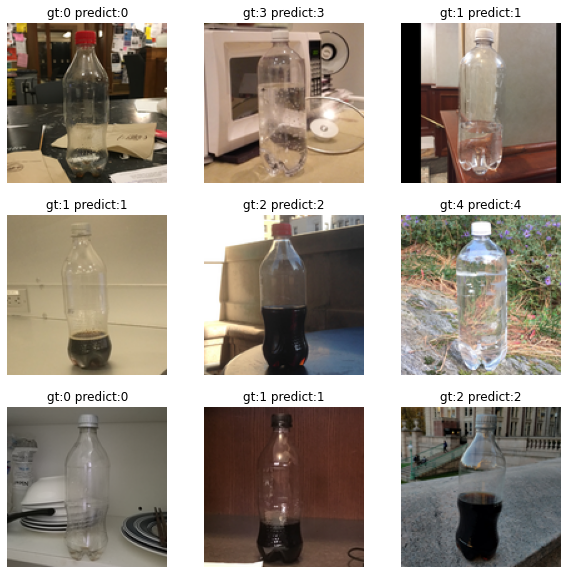

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(2):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        test_img =  tf.expand_dims(images[i], 0)
        predictions = model.predict(test_img)
        result = predictions.argmax()
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('gt:'+str(int(labels[i]))+' predict:'+str(result))
        plt.axis("off")

Open the TensorBoard to visualize the training process.

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir logs/ --bind_all